In [69]:
import os
import pickle

from graph_traffic.dataloading import graph_dataset, npzDataset
from graph_traffic.dcrnn import DiffConv
from graph_traffic.config import project_path
from graph_traffic.model import GraphRNN
from graph_traffic.train import train, eval, predict
from graph_traffic.utils import NormalizationLayer, masked_mae_loss
from graph_traffic.get_data import get_data, plot_graph

import matplotlib.pyplot as plt

from datetime import datetime
from torch.utils.data import DataLoader
import dgl
import torch
from functools import partial

training_time = datetime.now().strftime("%Y%m%d_%H%M%S")
print(training_time)

20220507_141527


## 0. Define training parameters

In [70]:
args = dict(
    n_points=None,
    batch_size=64,
    diffsteps=2,
    decay_steps=2000,
    lr=0.01,
    minimum_lr=2e-6,
    epochs=100,
    max_grad_norm=5.0,
    num_workers=0,
    model="dcrnn",
    gpu=-1,
    num_heads=2, # relevant for model="gaan"
    out_feats=2 * 256,
    num_layers=2
)

n_points = args["n_points"]
batch_size = args["batch_size"]
diffsteps = args["diffsteps"]
decay_steps = args["decay_steps"]
lr = args["lr"]
minimum_lr = args["minimum_lr"]
epochs = args["epochs"]
max_grad_norm = args["max_grad_norm"]
num_workers = args["num_workers"]
model = args["model"]
gpu = args["gpu"]
num_heads = args["num_heads"]
out_feats = args["out_feats"]
num_layers = args["num_layers"]


In [71]:
if gpu == -1:
    device = torch.device('cpu')
else:
    device = torch.device('cuda:{}'.format(gpu))

## 1. Load data

In [72]:
data_args = dict(
    ids_list=[3954, 3973, 3976, 3977, 3978],
    rain="ordinal",
    wind="wind_speed",
    season="ordinal",
    month="spline",
    day_of_month="trigonometric",
    hour="spline",
    interactions=None,
    seq_len=12,
    with_graph=True,
    from_date="2019-03-01",
    to_date="2019-03-31",
    dataset_name = "small"
)
ids_list = data_args["ids_list"]
rain = data_args["rain"]
wind = data_args["wind"]
season = data_args["season"]
month = data_args["month"]
day_of_month = data_args["day_of_month"]
hour = data_args["hour"]
interactions = data_args["interactions"]
seq_len = data_args["seq_len"]
with_graph = data_args["with_graph"]
from_date = data_args["from_date"]
to_date = data_args["to_date"]
dataset_name = data_args["dataset_name"]

### Save variables in text file for the records

In [73]:
training_folder = f"{project_path}/training_history/{training_time}"
os.mkdir(training_folder)
with open(f"{training_folder}/learning_args.pkl", "wb") as f:
    pickle.dump(args, f)
with open(f"{training_folder}/data_args.pkl", "wb") as f:
    pickle.dump(data_args, f)

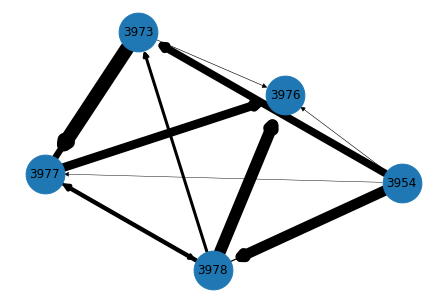

In [74]:
x, y, g = get_data(ids_list, seq_len, rain, wind, season, month, day_of_month, hour, interactions, with_graph, from_date, to_date, dataset_name)
plot_graph(g, ids_list, save_dir=training_folder)

In [75]:
g.edata

{'weight': tensor([0.2523, 0.0192, 0.0155, 0.3520, 0.0200, 0.4712, 0.2180, 0.2915, 0.1000,
        0.0416, 0.1000, 0.3932, 0.1465], dtype=torch.float64)}

In [76]:
g = graph_dataset(dataset_name)
train_data = npzDataset(dataset_name, "train", n_points)
test_data = npzDataset(dataset_name, "test", n_points)
valid_data = npzDataset(dataset_name, "valid", n_points)

seq_len = train_data.x.shape[1]
in_feats = train_data.x.shape[-1]

In [77]:
train_data.x.shape, train_data.y.shape

((1714, 12, 5, 36), (1714, 12, 5, 36))

In [78]:
valid_data.x.shape, valid_data.y.shape

((571, 12, 5, 36), (571, 12, 5, 36))

In [79]:
test_data.x.shape, test_data.y.shape

((572, 12, 5, 36), (572, 12, 5, 36))

In [80]:
train_loader = DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(
    valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

normalizer = NormalizationLayer(train_data.min, train_data.max)

## 2. Define the model

In [81]:
if model == "dcrnn":
    batch_g = dgl.batch([g] * batch_size).to(device)
    out_gs, in_gs = DiffConv.attach_graph(batch_g, diffsteps)
    net = partial(DiffConv, k=diffsteps, in_graph_list=in_gs, out_graph_list=out_gs)
elif model == 'gaan':
    print("not available")

dcrnn = GraphRNN(in_feats=in_feats,
                 out_feats=out_feats,
                 seq_len=seq_len,
                 num_layers=num_layers,
                 net=net,
                 decay_steps=decay_steps).to(device)

## 3. Define learning parameters

In [82]:
optimizer = torch.optim.Adam(dcrnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

loss_fn = masked_mae_loss

## 4. Train model

Después de hacer el cambio sigmoid -> tanh

In [ ]:
train_losses = []
valid_losses = []
test_losses = []
for e in range(epochs):
    train(dcrnn, g, train_loader, optimizer, scheduler, normalizer, loss_fn, device, batch_size, max_grad_norm, minimum_lr)
    train_loss = eval(dcrnn, g, train_loader, normalizer, loss_fn, device, batch_size)
    valid_loss = eval(dcrnn, g, valid_loader, normalizer, loss_fn, device, batch_size)
    test_loss = eval(dcrnn, g, test_loader, normalizer, loss_fn, device, batch_size)
    print(f"Epoch: {e} Train Loss: {train_loss} Valid Loss: {valid_loss} Test Loss: {test_loss}")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_losses.append(test_loss)

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(train_losses, label="train")
    ax.plot(valid_losses, label="validation")
    ax.plot(test_losses, label="test")
    plt.legend()
    plt.savefig(f"{training_folder}/learning_curve.svg")

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 0 Train Loss: 273.87219263320515 Valid Loss: 307.7592408839538 Test Loss: 281.9183245232579


In [ ]:


os.mkdir(f"{training_folder}/losses")
with open(f"{training_folder}/losses/train.pkl", "wb") as f:
    pickle.dump(train_losses, f)
with open(f"{training_folder}/losses/valid.pkl", "wb") as f:
    pickle.dump(valid_losses, f)
with open(f"{training_folder}/losses/test.pkl", "wb") as f:
    pickle.dump(test_losses, f)

## 5. Save model

In [ ]:
torch.save(dcrnn.state_dict(), f"{training_folder}/model.pt")

## 6. Try model

In [ ]:
for i, (x, y) in enumerate(train_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break

for i in range(10):
    fig, ax = plt.subplots()
    #ax.set_title(f"de {(y[:, i, 1]*24).min().numpy()} a  {(y[:, i, 1]*24).max().numpy()}, sensor{i%5+1}")
    ax.plot(y[:, i, 0].detach().numpy(), label="real")
    ax.plot(y_pred[:, i, 0].detach().numpy(), label="pred")
    plt.legend()

In [ ]:
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())

In [ ]:
for i, (x, y) in enumerate(valid_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())

In [ ]:
for i, (x, y) in enumerate(test_loader):
    #x, y, x_norm, y_norm, batch_graph = prepare_data(g.to(device), x, y, normalizer, args.batch_size, device)
    #y_pred = predict(dcrnn, batch_graph, x_norm, y_norm, normalizer, device, i)
    dcrnn.eval()
    y, y_pred = predict(x, y, batch_size, g.to(device), dcrnn, device, normalizer)
    break
plt.scatter(y.detach().numpy().ravel(), y_pred.detach().numpy().ravel())